<a href="https://colab.research.google.com/github/tahamokfi/covid_19/blob/master/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this analysis is to incorporate CHR (county health ranking) data to find possible relationships between COVID-19 deaths/cases and county-level variables. The CHR dataset can be considered as one of the major sources of county-level Social Determinants of Health statistics. Also, COVID-19 death/case datasets are acquired through the usafacts.org website.

The initial results show a possible relationship between COVID-19 and some variables such as Income inequality, Severe housing problems, Insufficient sleep, % of the population that is non-Hispanic Black or African American, Physical inactivity, and even suicide rate.

The results shown here need more in-depth analysis and interpreting current numbers and figures require extensive experiments using more granular data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sys
sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Download datasets
## download CHR data : www.countyhealthrankings.org
## County Health Ranking: The annual Rankings provide a revealing snapshot of how health is influenced by where we live, learn, work, and play. They provide a starting point for change in communities.
chr_2020 = pd.read_csv('https://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2020.csv', skiprows=1) #skip the first row
dict_data = pd.read_excel('https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2020_1.xlsx')
## download US facts data for Covid-19: www.usafacts.org
## The covid_death table contains the death statistics by the US counties and the covid_case provides the case statistics by county
covid_death = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv')
covid_case = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')

In [3]:
# select the latest data from usafacts.org since the table being updated every day.
## death
latest_death_res = np.max(covid_death.columns[4:])
print ('Latest date of available data: ',latest_death_res)
latest_death = covid_death[['countyFIPS',latest_death_res]][covid_death['countyFIPS']!=0] #exclude the state data
latest_death.columns = ['fipscode','covid_death']
## case
latest_case_res = np.max(covid_case.columns[4:])
latest_case = covid_case[['countyFIPS',latest_case_res]][covid_death['countyFIPS']!=0] #exclude the state data
latest_case.columns = ['fipscode','covid_case']

Latest date of available data:  4/9/20


In [4]:
# join CHR to death/case statistics using FIPS code
join_death = pd.merge(chr_2020, latest_death, how='inner', on = 'fipscode')
join_all = pd.merge(join_death, latest_case, how='inner', on = 'fipscode')
print ('Total number of counties in the table is: ', join_all.shape[0])

Total number of counties in the table is:  3143


This number matches the Wikipedia referenced number of 3143. What a perfect match!
https://en.wikipedia.org/wiki/List_of_United_States_counties_and_county_equivalents#cite_ref-3

In [0]:
# create the death rate and case rate using CHR population for each county
join_all['death_per_capita'] = join_all['covid_death']/join_all['v051_rawvalue']
join_all['case_per_capita'] = join_all['covid_case']/join_all['v051_rawvalue']

The death per capita and case per capita are created so that they can be comparable with the logic of some of the available variables in CHR. Here the variable "v051_rawvalue" is a resident population in that county and COVID_death and COVID_case are divided by this value to create the per capita variables.

In [7]:
# quantile of COVID death
print (np.round(np.quantile(join_all.sort_values(['covid_death'])['covid_death'],[0.65,0.8,0.9,0.95,0.99,0.995,0.999]),1))

[  0.    1.    4.   12.   78.6 191.  771.8]


The 65 percentile of COVID death based on the counties is 0, which means 65% of the counties have not experienced any death caused by COVID-19. Also, 90 percentile of COVID death is equal to 4, which means 90% of the US counties had 4 or less death caused by COVID-19.

In [0]:
# function for running EDA and regression analysis
## The aim is to provide some exploratory data analysis and linear regression analysis to find the relationship between available CHR variables and COVID statistics
def eda_covid_chr(xvar ='v001_rawvalue', target_var = 'death_rate', filter_var = 'covid_death', min_prec = None, max_prec = None, r2_limit = 0.1):
  """
  This is the function for EDA and regression

  Parameters
  ----------
    xvar: The independent variable from CHR
    target: The dependent variable which can be death_rate or case_rate
    filter_var: The variable to filter data based on percentile
    min_prec: Minimum percentile of filter_var to subset the counties based on that
    min_prec: Maximum percentile of filter_var to subset the counties based on that
    r2_limit: Threshold for R2 in order to show the results

  Returns
  -------
    EDA report based on selected threshold
  """
  # extract the name and desc of the variable from data dict
  meas_txt = dict_data[dict_data['Variable Name']==xvar]['Measure'].tolist()[0][:-10]
  desc_txt = dict_data[dict_data['Variable Name']==xvar]['Description'].tolist()[0]
  
  # filter data based on quantile of the filter_var 
  target_quant = np.quantile(join_all[filter_var],[min_prec, max_prec])
  dt_used = join_all[(join_all[filter_var] >= target_quant[0]) & (join_all[filter_var] <= target_quant[1])]
  
  # remove the rows with null values of var from CHR
  dt_used = dt_used[~dt_used[xvar].isna()]
  
  # if continue
  if dt_used.shape[0] > 21:
    # regression fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(dt_used[target_var], dt_used[xvar])
    r2_value = r_value**2

    # calculate the correlation
    corr_value = np.corrcoef(dt_used[target_var], dt_used[xvar])[0][1]

    if np.abs(r2_value) >= r2_limit:
      print ('\n','Variable name: ', meas_txt)
      print ('\n','Variable description: ', desc_txt)
      print ('\n','Number of counties for this specific comparison: ', dt_used.shape[0])
      print ('\n','Correlation between '+ target_var + ' and ' + meas_txt + ' is: ', np.round(corr_value,2))
      print ('\n','R-squared between '+ target_var + ' and ' + meas_txt + ' is: ', np.round(r2_value,2))
      print ('\n','Sample data','\n',dt_used[[target_var,xvar]].head(3))
      # plot the relationship
      plt_sns = sns.jointplot(x=target_var, y=xvar, data=dt_used, kind="reg",color = 'blue',)
      plt_sns.ax_joint.set_ylabel(meas_txt)
      plt.show()
      return [xvar, meas_txt, target_var, corr_value,np.round(r2_value,2)] #return detailed info

In [9]:
# select all the columns from CHR with raw values
## these columns contain the major health-related variables
all_cols = join_all.columns[6:786]
col_raw_names = [i for i in all_cols if 'rawvalue' in i]
print ('Number of CHR variables: ',len(col_raw_names))

Number of CHR variables:  107


The rest of this section is about finding the possible relationships between CHR variable with COVID-19 major statitics which are: 1) Death number 2) Death per capita 3) Case number and 4) Case per capita

In order to focus on the counties with the higher death rate the min and max threshold for number of COVID death are used in the function. Also, to just represent significant relationships, only those CHR variable that have greater than equal 0.1 in R2 with the dependent variables are printed out. Around 160 counties are selected for this part of the analysis.


 Variable name:  Alcohol-impaired driving deaths

 Variable description:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Alcohol-impaired driving deaths is:  -0.38

 R-squared between covid_death and Alcohol-impaired driving deaths is:  0.15

 Sample data 
      covid_death  v134_rawvalue
98            15       0.226721
103           39       0.257039
106           20       0.282486


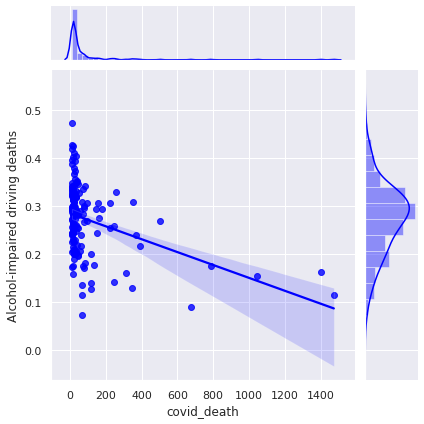


 Variable name:  Income inequality

 Variable description:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Income inequality is:  0.4

 R-squared between covid_death and Income inequality is:  0.16

 Sample data 
      covid_death  v044_rawvalue
98            15       5.076507
103           39       4.481822
106           20       4.773894


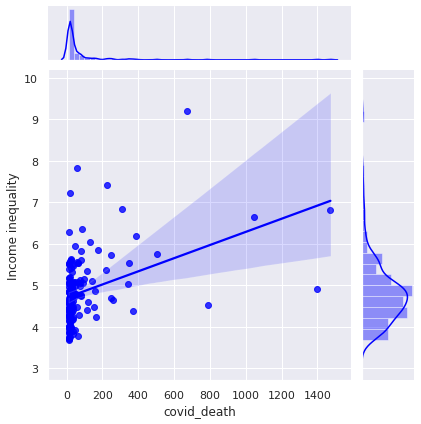


 Variable name:  Injury deaths

 Variable description:  Number of deaths due to injury per 100,000 population.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Injury deaths is:  -0.32

 R-squared between covid_death and Injury deaths is:  0.1

 Sample data 
      covid_death  v135_rawvalue
98            15     103.376932
103           39      75.113150
106           20      87.283698


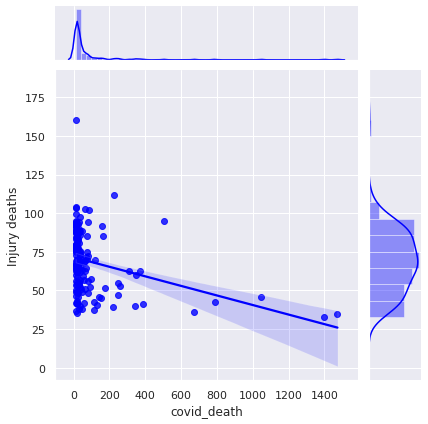


 Variable name:  Severe housing problems

 Variable description:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Severe housing problems is:  0.55

 R-squared between covid_death and Severe housing problems is:  0.3

 Sample data 
      covid_death  v136_rawvalue
98            15       0.253035
103           39       0.181831
106           20       0.195023


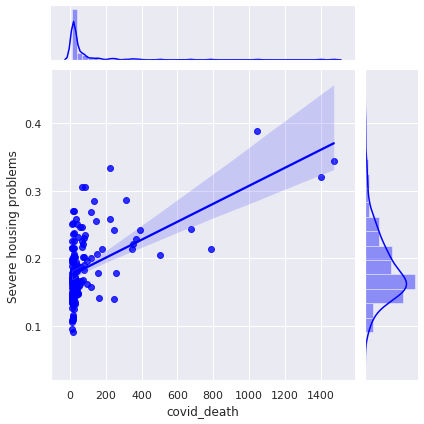


 Variable name:  Driving alone to work

 Variable description:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Driving alone to work is:  -0.67

 R-squared between covid_death and Driving alone to work is:  0.45

 Sample data 
      covid_death  v067_rawvalue
98            15       0.694835
103           39       0.762649
106           20       0.769229


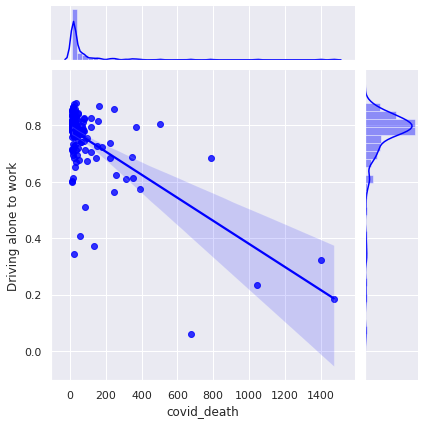


 Variable name:  Long commute - driving alone

 Variable description:  Among workers who commute in their car alone, the percentage that commute more than 30
minutes.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Long commute - driving alone is:  0.35

 R-squared between covid_death and Long commute - driving alone is:  0.12

 Sample data 
      covid_death  v137_rawvalue
98            15          0.158
103           39          0.376
106           20          0.349


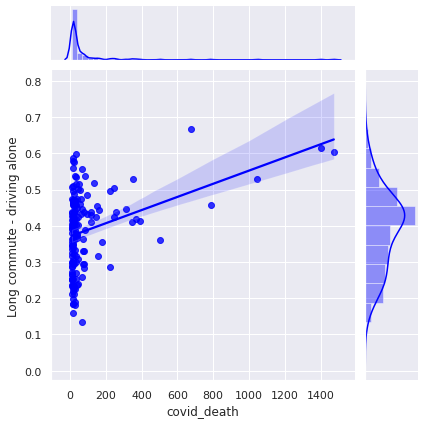


 Variable name:  HIV prevalence

 Variable description:  Number of people aged 13 years and older living with a diagnosis of human immunodeficiency
virus (HIV) infection per 100,000 population.

 Number of counties for this specific comparison:  148

 Correlation between covid_death and HIV prevalence is:  0.37

 R-squared between covid_death and HIV prevalence is:  0.14

 Sample data 
      covid_death  v061_rawvalue
98            15          113.7
103           39          309.1
106           20          281.4


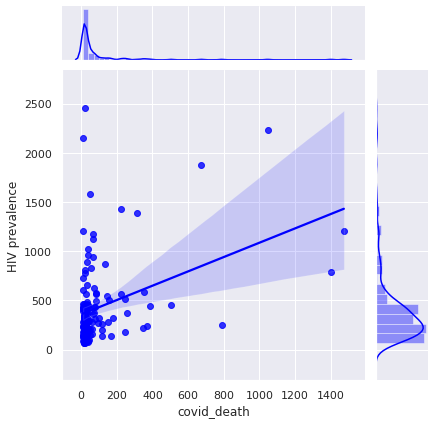


 Variable name:  Limited access to healthy foods

 Variable description:  Percentage of population who are low-income and do not live close to a grocery store.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Limited access to healthy foods is:  -0.34

 R-squared between covid_death and Limited access to healthy foods is:  0.12

 Sample data 
      covid_death  v083_rawvalue
98            15       0.138317
103           39       0.043995
106           20       0.076811


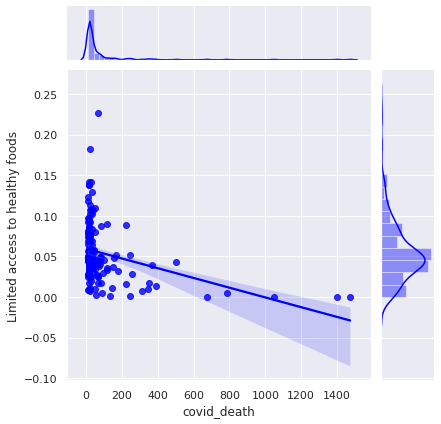


 Variable name:  Residential segregation - Black/White

 Variable description:  Index of dissimilarity where higher values indicate greater residential segregation between
Black and White county residents.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Residential segregation - Black/White is:  0.35

 R-squared between covid_death and Residential segregation - Black/White is:  0.12

 Sample data 
      covid_death  v141_rawvalue
98            15      50.178052
103           39      41.705638
106           20      41.525754


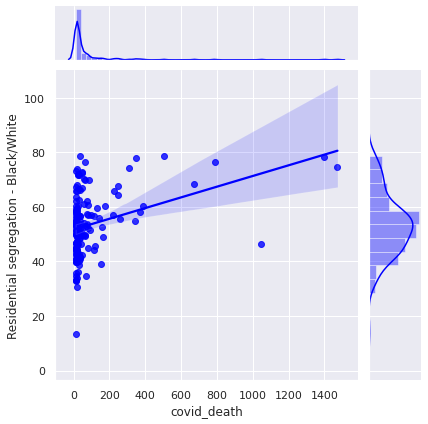


 Variable name:  Suicides

 Variable description:  Number of deaths due to suicide per 100,000 population (age-adjusted).

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Suicides is:  -0.38

 R-squared between covid_death and Suicides is:  0.14

 Sample data 
      covid_death  v161_rawvalue
98            15      25.127732
103           39      15.819633
106           20      18.571446


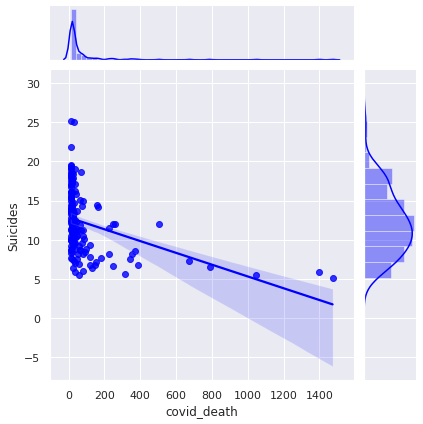


 Variable name:  Traffic volume

 Variable description:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Traffic volume is:  0.78

 R-squared between covid_death and Traffic volume is:  0.61

 Sample data 
      covid_death  v156_rawvalue
98            15     106.376388
103           39     885.046158
106           20    1864.797915


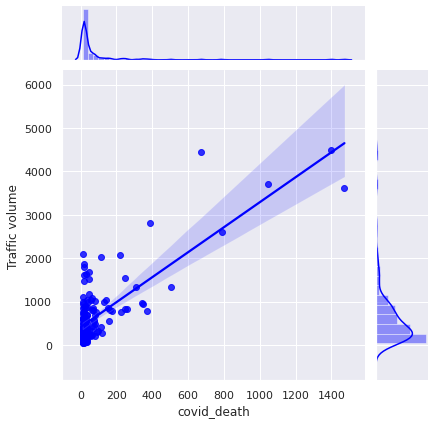


 Variable name:  Homeownership

 Variable description:  Percentage of occupied housing units that are owned.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Homeownership is:  -0.41

 R-squared between covid_death and Homeownership is:  0.17

 Sample data 
      covid_death  v153_rawvalue
98            15       0.605741
103           39       0.613580
106           20       0.623900


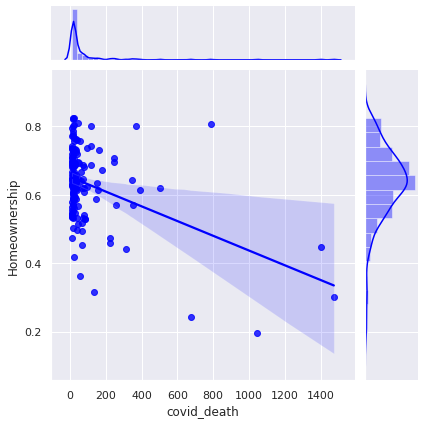


 Variable name:  Severe housing cost burden

 Variable description:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Severe housing cost burden is:  0.55

 R-squared between covid_death and Severe housing cost burden is:  0.3

 Sample data 
      covid_death  v154_rawvalue
98            15       0.168653
103           39       0.143364
106           20       0.156337


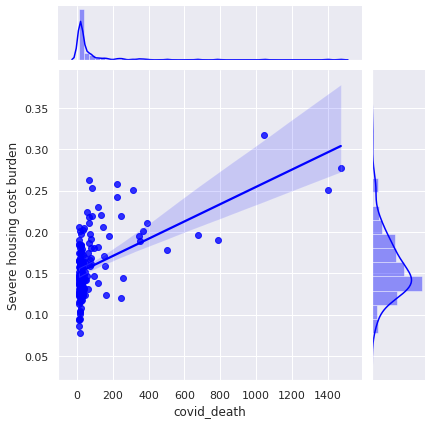


 Variable name:  % not proficient in English

 Variable description:  Percentage of population that is not proficient in English.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and % not proficient in English is:  0.43

 R-squared between covid_death and % not proficient in English is:  0.18

 Sample data 
      covid_death  v059_rawvalue
98            15       0.021676
103           39       0.051506
106           20       0.042099


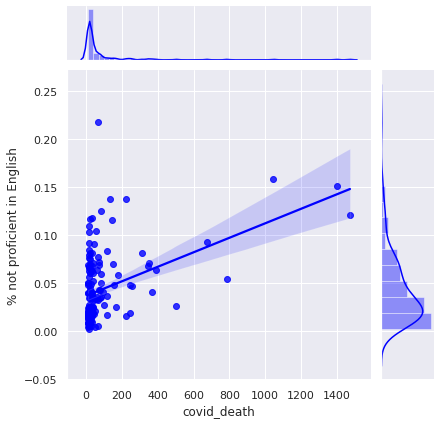


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v156_rawvalue,Traffic volume,covid_death,0.781123,0.61
1,v067_rawvalue,Driving alone to work,covid_death,-0.673609,0.45
2,v136_rawvalue,Severe housing problems,covid_death,0.548460,0.30
3,v154_rawvalue,Severe housing cost burden,covid_death,0.548761,0.30
4,v059_rawvalue,% not proficient in English,covid_death,0.429236,0.18
5,v153_rawvalue,Homeownership,covid_death,-0.406870,0.17
6,v044_rawvalue,Income inequality,covid_death,0.395855,0.16
7,v134_rawvalue,Alcohol-impaired driving deaths,covid_death,-0.381636,0.15
8,v061_rawvalue,HIV prevalence,covid_death,0.372433,0.14
9,v161_rawvalue,Suicides,covid_death,-0.378064,0.14


In [10]:
# explore the COVID death number relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'covid_death',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
covid_death_tbl = pd.DataFrame([i for i in res_list if i != None])
covid_death_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
covid_death_tbl = covid_death_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ") 
covid_death_tbl

It seems traffic volume in the county has a strong relationship with the number of death. Since most of COVID-19 hotspots are mega cities, this relationship seems meaningful. Also, Severe housing problems seems to have a signficant relationship with the number of deaths. Following variables in the table such as Homeownership and Income inequalities are just confirming the fact that, COVID-19 death can be strongly related to the financial situation of families and people leaving in the different US counties.



 Variable name:  Physical inactivity

 Variable description:  Percentage of adults age 20 and over reporting no leisure-time physical activity.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Physical inactivity is:  0.38

 R-squared between death_per_capita and Physical inactivity is:  0.14

 Sample data 
      death_per_capita  v070_rawvalue
98           0.000105          0.170
103          0.000009          0.204
106          0.000019          0.198


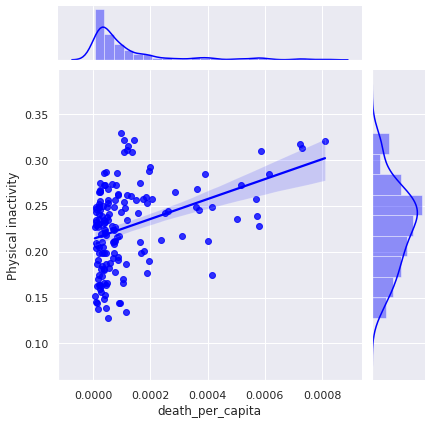


 Variable name:  Alcohol-impaired driving deaths

 Variable description:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Alcohol-impaired driving deaths is:  -0.33

 R-squared between death_per_capita and Alcohol-impaired driving deaths is:  0.11

 Sample data 
      death_per_capita  v134_rawvalue
98           0.000105       0.226721
103          0.000009       0.257039
106          0.000019       0.282486


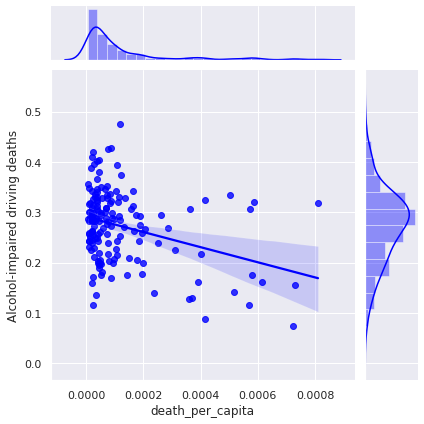


 Variable name:  Income inequality

 Variable description:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Income inequality is:  0.32

 R-squared between death_per_capita and Income inequality is:  0.1

 Sample data 
      death_per_capita  v044_rawvalue
98           0.000105       5.076507
103          0.000009       4.481822
106          0.000019       4.773894


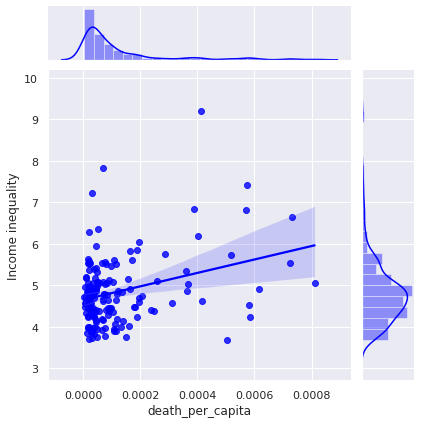


 Variable name:  Severe housing problems

 Variable description:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Severe housing problems is:  0.33

 R-squared between death_per_capita and Severe housing problems is:  0.11

 Sample data 
      death_per_capita  v136_rawvalue
98           0.000105       0.253035
103          0.000009       0.181831
106          0.000019       0.195023


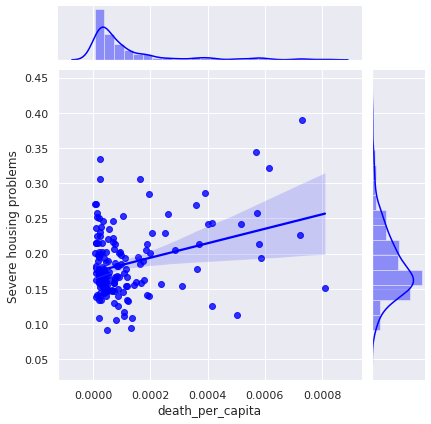


 Variable name:  Driving alone to work

 Variable description:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Driving alone to work is:  -0.36

 R-squared between death_per_capita and Driving alone to work is:  0.13

 Sample data 
      death_per_capita  v067_rawvalue
98           0.000105       0.694835
103          0.000009       0.762649
106          0.000019       0.769229


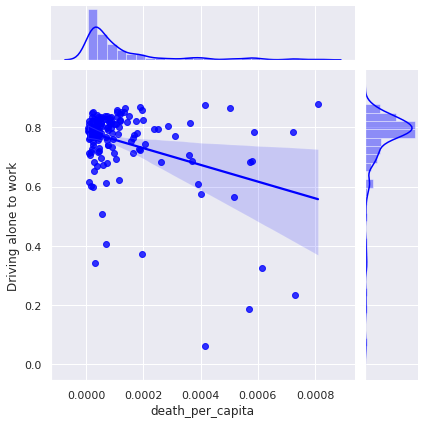


 Variable name:  Insufficient sleep

 Variable description:  Percentage of adults who report fewer than 7 hours of sleep on average.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Insufficient sleep is:  0.41

 R-squared between death_per_capita and Insufficient sleep is:  0.17

 Sample data 
      death_per_capita  v143_rawvalue
98           0.000105       0.306331
103          0.000009       0.342679
106          0.000019       0.309099


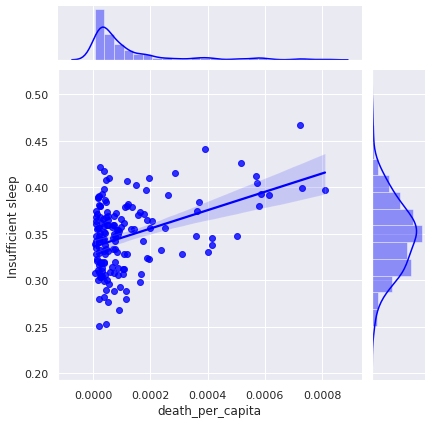


 Variable name:  Traffic volume

 Variable description:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Traffic volume is:  0.4

 R-squared between death_per_capita and Traffic volume is:  0.16

 Sample data 
      death_per_capita  v156_rawvalue
98           0.000105     106.376388
103          0.000009     885.046158
106          0.000019    1864.797915


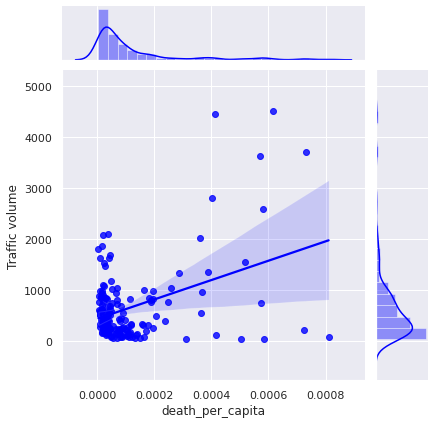


 Variable name:  Severe housing cost burden

 Variable description:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Severe housing cost burden is:  0.39

 R-squared between death_per_capita and Severe housing cost burden is:  0.15

 Sample data 
      death_per_capita  v154_rawvalue
98           0.000105       0.168653
103          0.000009       0.143364
106          0.000019       0.156337


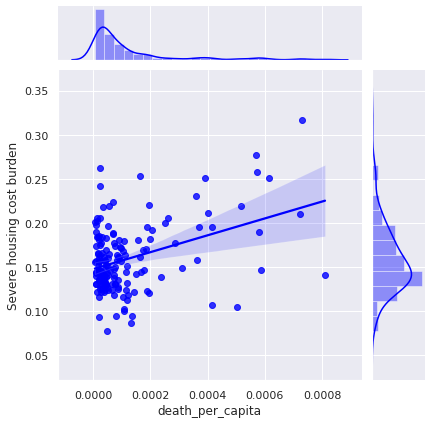


 Variable name:  % Non-Hispanic Black

 Variable description:  Percentage of population that is non-Hispanic Black or African American.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and % Non-Hispanic Black is:  0.33

 R-squared between death_per_capita and % Non-Hispanic Black is:  0.11

 Sample data 
      death_per_capita  v054_rawvalue
98           0.000105       0.012509
103          0.000009       0.054661
106          0.000019       0.033892


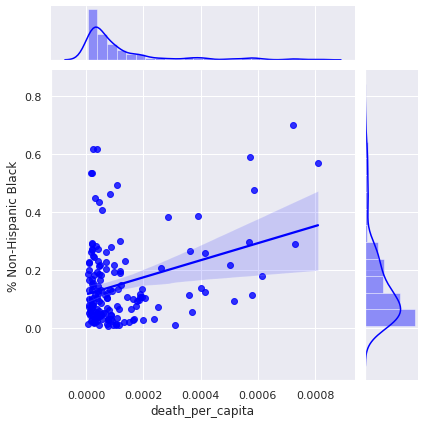


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v143_rawvalue,Insufficient sleep,death_per_capita,0.414616,0.17
1,v156_rawvalue,Traffic volume,death_per_capita,0.402009,0.16
2,v154_rawvalue,Severe housing cost burden,death_per_capita,0.392212,0.15
3,v070_rawvalue,Physical inactivity,death_per_capita,0.376048,0.14
4,v067_rawvalue,Driving alone to work,death_per_capita,-0.363098,0.13
5,v134_rawvalue,Alcohol-impaired driving deaths,death_per_capita,-0.332160,0.11
6,v136_rawvalue,Severe housing problems,death_per_capita,0.329723,0.11
7,v054_rawvalue,% Non-Hispanic Black,death_per_capita,0.327000,0.11
8,v044_rawvalue,Income inequality,death_per_capita,0.316555,0.10


In [11]:
# explore the covid death per capita relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'death_per_capita',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
death_rate_tbl = pd.DataFrame([i for i in res_list if i != None])
death_rate_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
death_rate_tbl = death_rate_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ")
death_rate_tbl

Based on the above results, it is clear that COVID-19 death per capita has a possitive relationship with insufficient sleep, Traffic volume, Severe housing cost burden, and even Physical inactivity. Comparing this table to the previous one (which was based on number of death overall), many features are shared and showed similar relationship. 



 Variable name:  Access to exercise opportunities

 Variable description:  Percentage of population with adequate access to locations for physical activity.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Access to exercise opportunities is:  0.33

 R-squared between covid_case and Access to exercise opportunities is:  0.11

 Sample data 
      covid_case  v132_rawvalue
98          210       0.828762
103        1689       0.916026
106         512       0.878463


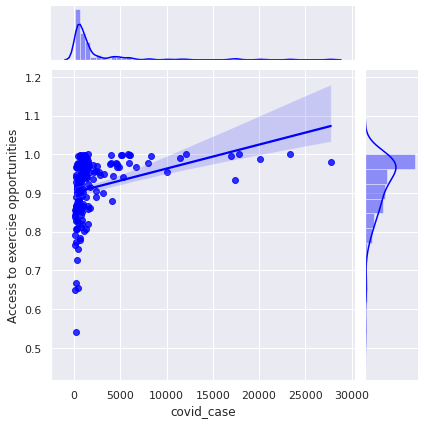


 Variable name:  Alcohol-impaired driving deaths

 Variable description:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Alcohol-impaired driving deaths is:  -0.39

 R-squared between covid_case and Alcohol-impaired driving deaths is:  0.16

 Sample data 
      covid_case  v134_rawvalue
98          210       0.226721
103        1689       0.257039
106         512       0.282486


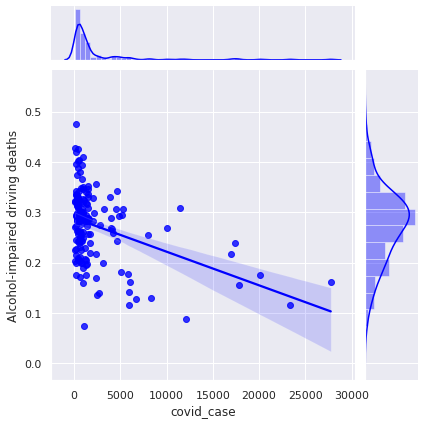


 Variable name:  Income inequality

 Variable description:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Income inequality is:  0.41

 R-squared between covid_case and Income inequality is:  0.17

 Sample data 
      covid_case  v044_rawvalue
98          210       5.076507
103        1689       4.481822
106         512       4.773894


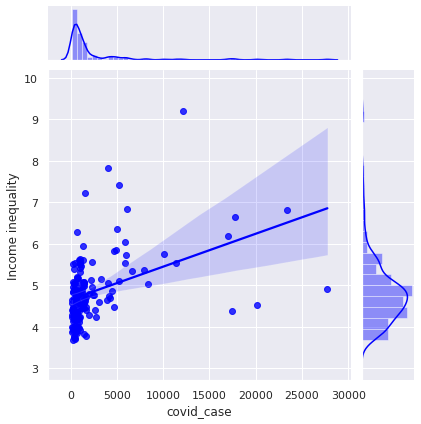


 Variable name:  Injury deaths

 Variable description:  Number of deaths due to injury per 100,000 population.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Injury deaths is:  -0.36

 R-squared between covid_case and Injury deaths is:  0.13

 Sample data 
      covid_case  v135_rawvalue
98          210     103.376932
103        1689      75.113150
106         512      87.283698


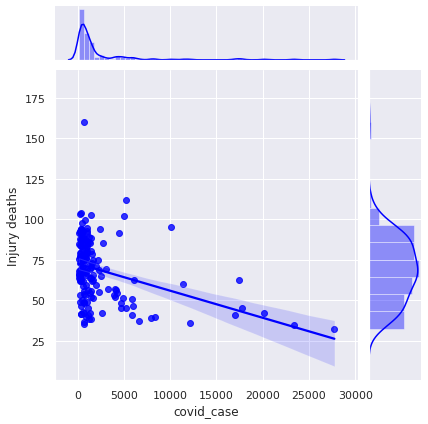


 Variable name:  Severe housing problems

 Variable description:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Severe housing problems is:  0.6

 R-squared between covid_case and Severe housing problems is:  0.36

 Sample data 
      covid_case  v136_rawvalue
98          210       0.253035
103        1689       0.181831
106         512       0.195023


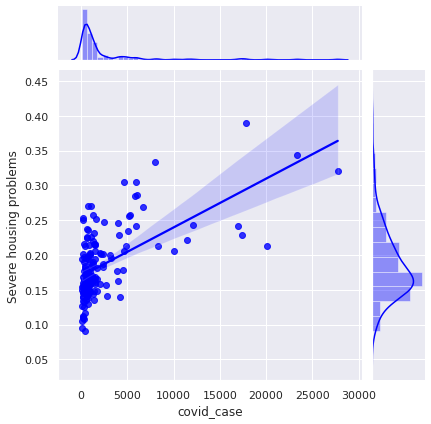


 Variable name:  Driving alone to work

 Variable description:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Driving alone to work is:  -0.64

 R-squared between covid_case and Driving alone to work is:  0.41

 Sample data 
      covid_case  v067_rawvalue
98          210       0.694835
103        1689       0.762649
106         512       0.769229


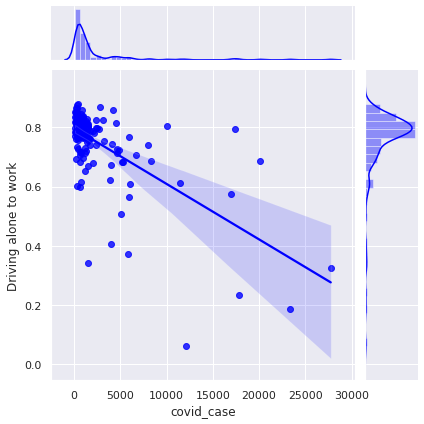


 Variable name:  Long commute - driving alone

 Variable description:  Among workers who commute in their car alone, the percentage that commute more than 30
minutes.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Long commute - driving alone is:  0.38

 R-squared between covid_case and Long commute - driving alone is:  0.14

 Sample data 
      covid_case  v137_rawvalue
98          210          0.158
103        1689          0.376
106         512          0.349


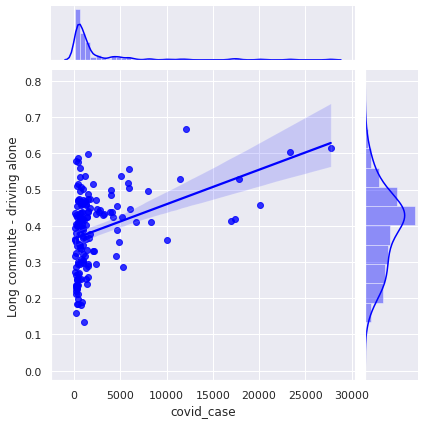


 Variable name:  Life expectancy

 Variable description:  Average number of years a person can expect to live.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Life expectancy is:  0.33

 R-squared between covid_case and Life expectancy is:  0.11

 Sample data 
      covid_case  v147_rawvalue
98          210      78.980006
103        1689      80.379855
106         512      79.566414


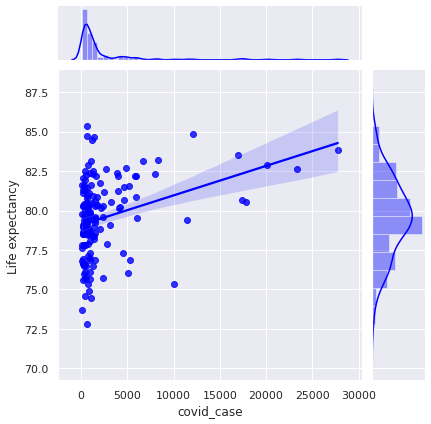


 Variable name:  HIV prevalence

 Variable description:  Number of people aged 13 years and older living with a diagnosis of human immunodeficiency
virus (HIV) infection per 100,000 population.

 Number of counties for this specific comparison:  148

 Correlation between covid_case and HIV prevalence is:  0.34

 R-squared between covid_case and HIV prevalence is:  0.12

 Sample data 
      covid_case  v061_rawvalue
98          210          113.7
103        1689          309.1
106         512          281.4


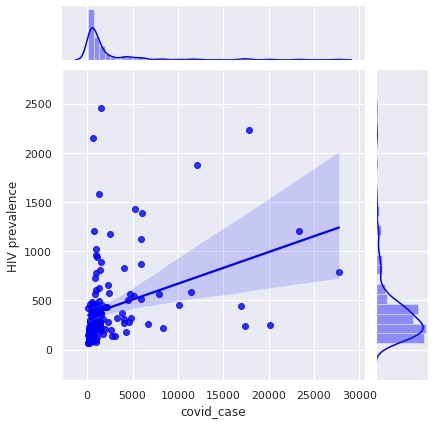


 Variable name:  Limited access to healthy foods

 Variable description:  Percentage of population who are low-income and do not live close to a grocery store.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Limited access to healthy foods is:  -0.4

 R-squared between covid_case and Limited access to healthy foods is:  0.16

 Sample data 
      covid_case  v083_rawvalue
98          210       0.138317
103        1689       0.043995
106         512       0.076811


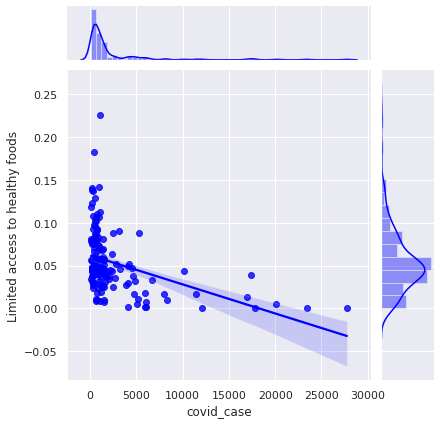


 Variable name:  Motor vehicle crash deaths

 Variable description:  Number of motor vehicle crash deaths per 100,000 population.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Motor vehicle crash deaths is:  -0.34

 R-squared between covid_case and Motor vehicle crash deaths is:  0.12

 Sample data 
      covid_case  v039_rawvalue
98          210      23.514505
103        1689      10.741381
106         512      11.480559


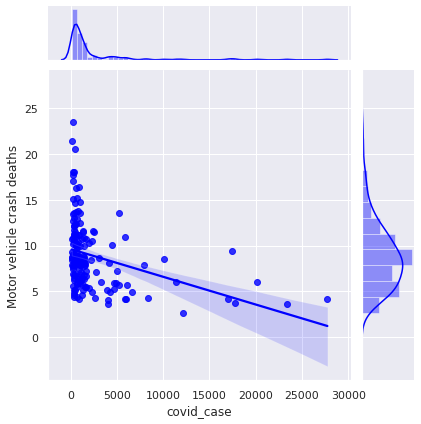


 Variable name:  Residential segregation - Black/White

 Variable description:  Index of dissimilarity where higher values indicate greater residential segregation between
Black and White county residents.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Residential segregation - Black/White is:  0.39

 R-squared between covid_case and Residential segregation - Black/White is:  0.15

 Sample data 
      covid_case  v141_rawvalue
98          210      50.178052
103        1689      41.705638
106         512      41.525754


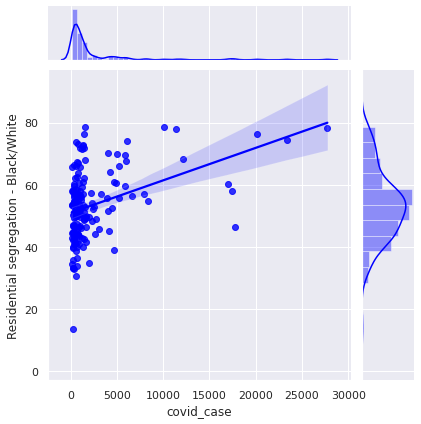


 Variable name:  Suicides

 Variable description:  Number of deaths due to suicide per 100,000 population (age-adjusted).

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Suicides is:  -0.46

 R-squared between covid_case and Suicides is:  0.21

 Sample data 
      covid_case  v161_rawvalue
98          210      25.127732
103        1689      15.819633
106         512      18.571446


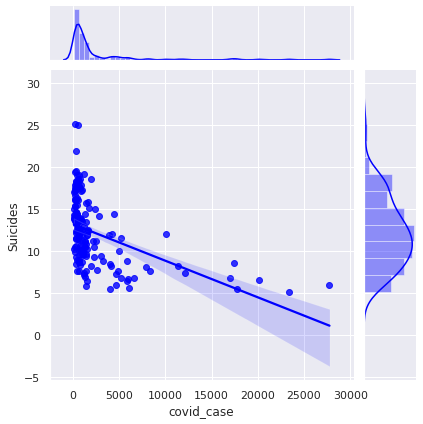


 Variable name:  Juvenile arrests

 Variable description:  Rate of delinquency cases per 1,000 juveniles

 Number of counties for this specific comparison:  136

 Correlation between covid_case and Juvenile arrests is:  -0.38

 R-squared between covid_case and Juvenile arrests is:  0.14

 Sample data 
      covid_case  v158_rawvalue
98          210      38.045113
103        1689      21.914849
106         512      47.690743


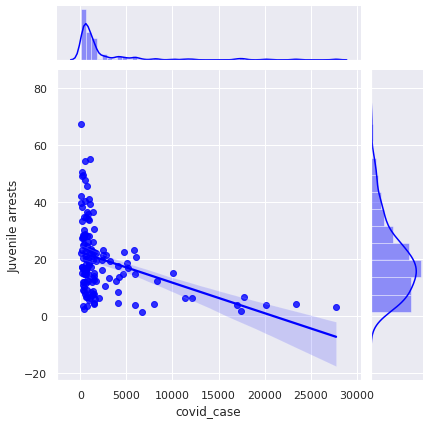


 Variable name:  Traffic volume

 Variable description:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Traffic volume is:  0.77

 R-squared between covid_case and Traffic volume is:  0.6

 Sample data 
      covid_case  v156_rawvalue
98          210     106.376388
103        1689     885.046158
106         512    1864.797915


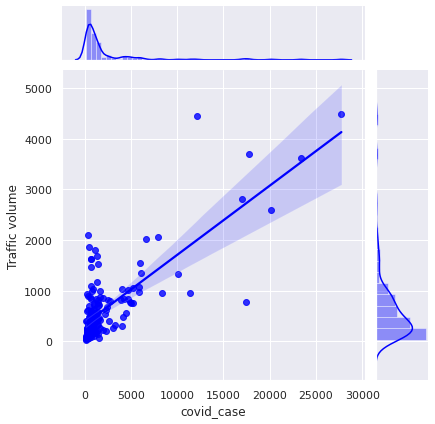


 Variable name:  Homeownership

 Variable description:  Percentage of occupied housing units that are owned.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Homeownership is:  -0.36

 R-squared between covid_case and Homeownership is:  0.13

 Sample data 
      covid_case  v153_rawvalue
98          210       0.605741
103        1689       0.613580
106         512       0.623900


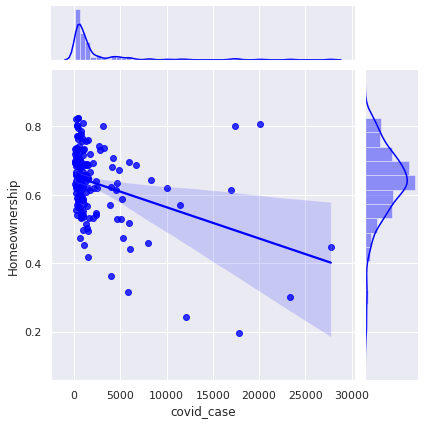


 Variable name:  Severe housing cost burden

 Variable description:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Severe housing cost burden is:  0.62

 R-squared between covid_case and Severe housing cost burden is:  0.38

 Sample data 
      covid_case  v154_rawvalue
98          210       0.168653
103        1689       0.143364
106         512       0.156337


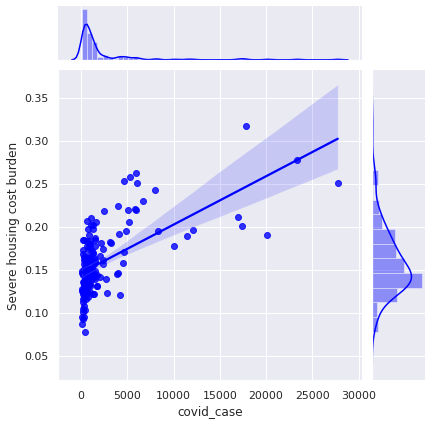


 Variable name:  Population

 Variable description:  Resident population.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Population is:  0.34

 R-squared between covid_case and Population is:  0.12

 Sample data 
      covid_case  v051_rawvalue
98          210         142854
103        1689        4410824
106         512        1039073


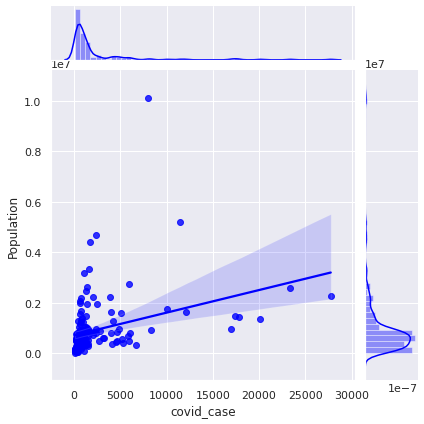


 Variable name:  % Non-Hispanic White

 Variable description:  Percentage of population that is non-Hispanic White.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and % Non-Hispanic White is:  -0.32

 R-squared between covid_case and % Non-Hispanic White is:  0.1

 Sample data 
      covid_case  v126_rawvalue
98          210       0.539908
103        1689       0.549021
106         512       0.514314


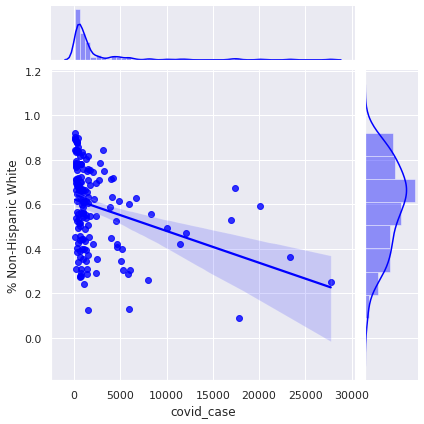


 Variable name:  % not proficient in English

 Variable description:  Percentage of population that is not proficient in English.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and % not proficient in English is:  0.49

 R-squared between covid_case and % not proficient in English is:  0.24

 Sample data 
      covid_case  v059_rawvalue
98          210       0.021676
103        1689       0.051506
106         512       0.042099


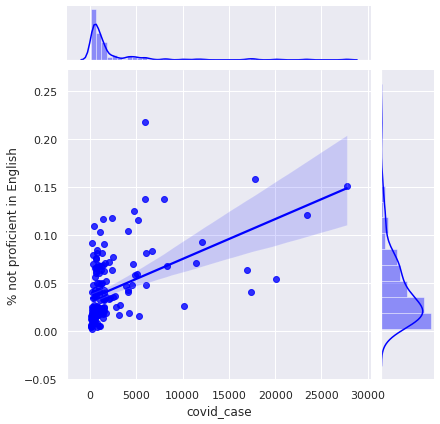


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v156_rawvalue,Traffic volume,covid_case,0.772478,0.60
1,v067_rawvalue,Driving alone to work,covid_case,-0.643591,0.41
2,v154_rawvalue,Severe housing cost burden,covid_case,0.616145,0.38
3,v136_rawvalue,Severe housing problems,covid_case,0.601714,0.36
4,v059_rawvalue,% not proficient in English,covid_case,0.491698,0.24
5,v161_rawvalue,Suicides,covid_case,-0.456254,0.21
6,v044_rawvalue,Income inequality,covid_case,0.413086,0.17
7,v083_rawvalue,Limited access to healthy foods,covid_case,-0.401501,0.16
8,v134_rawvalue,Alcohol-impaired driving deaths,covid_case,-0.394613,0.16
9,v141_rawvalue,Residential segregation - Black/White,covid_case,0.391073,0.15


In [12]:
# explore the covid case relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'covid_case',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
covid_case_tbl = pd.DataFrame([i for i in res_list if i != None])
covid_case_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
covid_case_tbl = covid_case_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ")
covid_case_tbl

With respect to the relationship between CHR variables and COVID-19 cases statistics, again lots of similar variables show similar strong relationships some of which are Severe housing cost burden, traffic volume, Driving alone to work, % not proficient in English, Income inequality, etc.


 Variable name:  Physical inactivity

 Variable description:  Percentage of adults age 20 and over reporting no leisure-time physical activity.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Physical inactivity is:  0.32

 R-squared between case_per_capita and Physical inactivity is:  0.1

 Sample data 
      case_per_capita  v070_rawvalue
98          0.001470          0.170
103         0.000383          0.204
106         0.000493          0.198


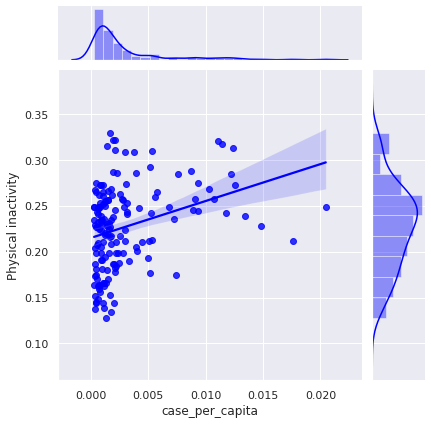


 Variable name:  Alcohol-impaired driving deaths

 Variable description:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Alcohol-impaired driving deaths is:  -0.35

 R-squared between case_per_capita and Alcohol-impaired driving deaths is:  0.12

 Sample data 
      case_per_capita  v134_rawvalue
98          0.001470       0.226721
103         0.000383       0.257039
106         0.000493       0.282486


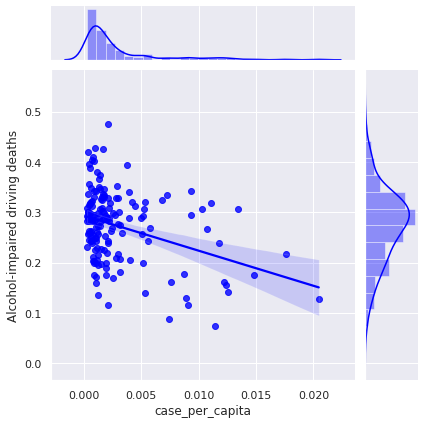


 Variable name:  Income inequality

 Variable description:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Income inequality is:  0.38

 R-squared between case_per_capita and Income inequality is:  0.14

 Sample data 
      case_per_capita  v044_rawvalue
98          0.001470       5.076507
103         0.000383       4.481822
106         0.000493       4.773894


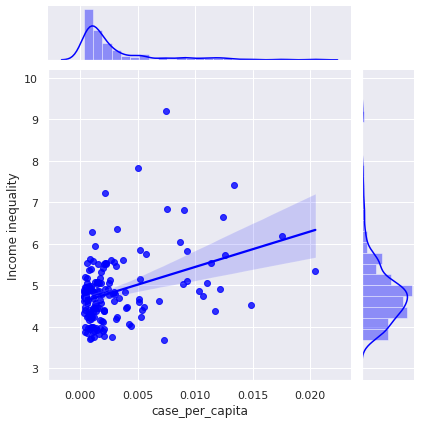


 Variable name:  Severe housing problems

 Variable description:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Severe housing problems is:  0.44

 R-squared between case_per_capita and Severe housing problems is:  0.19

 Sample data 
      case_per_capita  v136_rawvalue
98          0.001470       0.253035
103         0.000383       0.181831
106         0.000493       0.195023


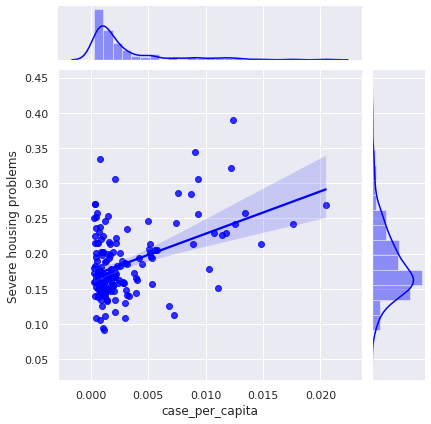


 Variable name:  Driving alone to work

 Variable description:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Driving alone to work is:  -0.4

 R-squared between case_per_capita and Driving alone to work is:  0.16

 Sample data 
      case_per_capita  v067_rawvalue
98          0.001470       0.694835
103         0.000383       0.762649
106         0.000493       0.769229


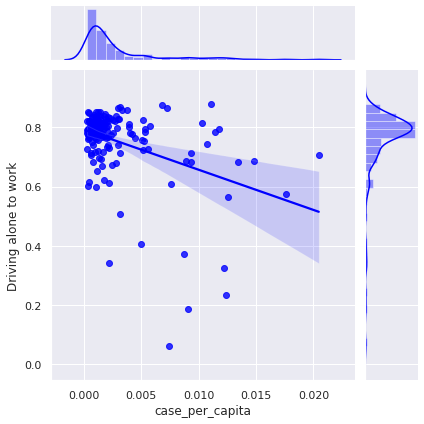


 Variable name:  Insufficient sleep

 Variable description:  Percentage of adults who report fewer than 7 hours of sleep on average.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Insufficient sleep is:  0.39

 R-squared between case_per_capita and Insufficient sleep is:  0.15

 Sample data 
      case_per_capita  v143_rawvalue
98          0.001470       0.306331
103         0.000383       0.342679
106         0.000493       0.309099


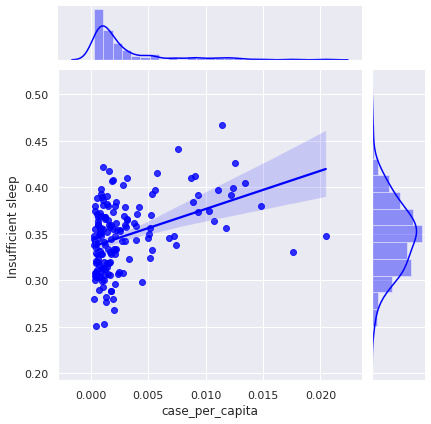


 Variable name:  Suicides

 Variable description:  Number of deaths due to suicide per 100,000 population (age-adjusted).

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Suicides is:  -0.43

 R-squared between case_per_capita and Suicides is:  0.18

 Sample data 
      case_per_capita  v161_rawvalue
98          0.001470      25.127732
103         0.000383      15.819633
106         0.000493      18.571446


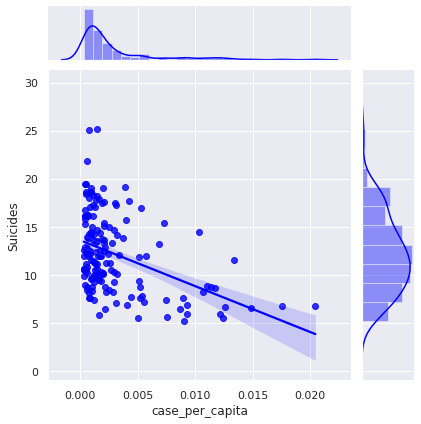


 Variable name:  Traffic volume

 Variable description:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Traffic volume is:  0.46

 R-squared between case_per_capita and Traffic volume is:  0.21

 Sample data 
      case_per_capita  v156_rawvalue
98          0.001470     106.376388
103         0.000383     885.046158
106         0.000493    1864.797915


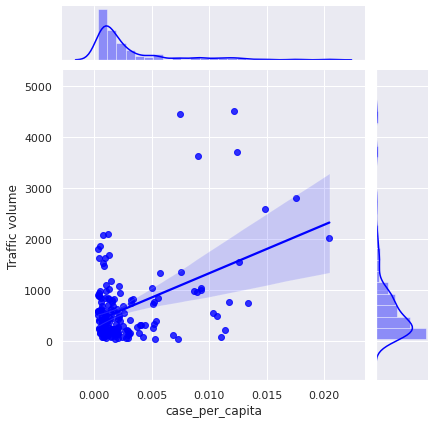


 Variable name:  Severe housing cost burden

 Variable description:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between case_per_capita and Severe housing cost burden is:  0.52

 R-squared between case_per_capita and Severe housing cost burden is:  0.27

 Sample data 
      case_per_capita  v154_rawvalue
98          0.001470       0.168653
103         0.000383       0.143364
106         0.000493       0.156337


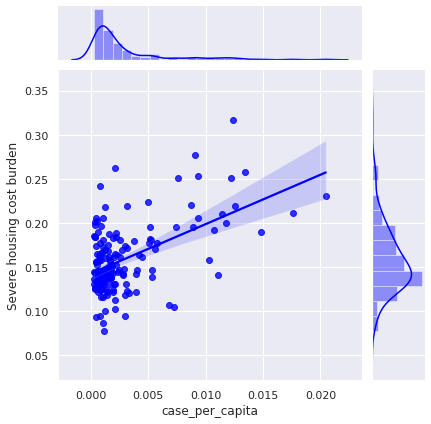


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v154_rawvalue,Severe housing cost burden,case_per_capita,0.523334,0.27
1,v156_rawvalue,Traffic volume,case_per_capita,0.457216,0.21
2,v136_rawvalue,Severe housing problems,case_per_capita,0.440100,0.19
3,v161_rawvalue,Suicides,case_per_capita,-0.426050,0.18
4,v067_rawvalue,Driving alone to work,case_per_capita,-0.397645,0.16
5,v143_rawvalue,Insufficient sleep,case_per_capita,0.393465,0.15
6,v044_rawvalue,Income inequality,case_per_capita,0.378932,0.14
7,v134_rawvalue,Alcohol-impaired driving deaths,case_per_capita,-0.351239,0.12
8,v070_rawvalue,Physical inactivity,case_per_capita,0.317333,0.10


In [13]:
# explore the covid case per capita relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'case_per_capita',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
case_rate_tbl = pd.DataFrame([i for i in res_list if i != None])
case_rate_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
case_rate_tbl = case_rate_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ")
case_rate_tbl

Since there are some studies regarding the possible relationship between having diabetes and vulnerability to COVID-19 the following section is showing the relationship between the top 129 US counties with the highest COVID-19 death per capita and the percentage of adults aged 20 and above with diabetes.


 Variable name:  Diabetes prevalence

 Variable description:  Percentage of adults aged 20 and above with diagnosed diabetes.

 Number of counties for this specific comparison:  160

 Correlation between death_per_capita and Diabetes prevalence is:  0.26

 R-squared between death_per_capita and Diabetes prevalence is:  0.07

 Sample data 
      death_per_capita  v060_rawvalue
98           0.000105          0.075
103          0.000009          0.089
106          0.000019          0.084


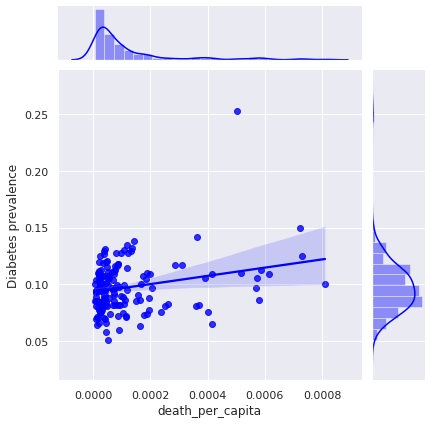

['v060_rawvalue',
 'Diabetes prevalence',
 'death_per_capita',
 0.25623614970174297,
 0.07]

In [14]:
eda_covid_chr(xvar = 'v060_rawvalue', target_var = 'death_per_capita',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.01)

Based on the available data, it is hard to identify a strong relationship between higher death rate and diabetes population. But certainly, with more data, the trajectory in the relationship suggests more in-depth analysis is needed in the future.